# Smart Meters in London: Data Analysis and ML model (Part 2/3)

There are three main objectives in this project, as stated below:

1. Create a ML algorithm to forecast the electricity consumption for one household considering the prior smart meter data we have. Hence, we could create a Dashboard with Tableau to show the results that end-user has. 


2. Classifying our portfolio clients according to their consumption, but also according to acorn classification. 


3. Analyse the influence of the weather into our energy consumption. This last step could be performed in two ways: considering only one household, or, on the contrary, aggregating all the demand we have in our 6000 clients. 

This second jupyter notebook wants to go deep into the first objective, analyzing the data coming from the energy cnsumption of different users, to see how a forecast algorithm can be developed, or clustering models can be done. In this case, the target end-user that will be assessed will be MAC000291, with a Standard Tariff.  

The structure of this notebook is as follows: 
1. Importing libraries and data preprocessing.

2.  Electricity consumption from end-user MAC000291. TIme Series Analysis

3. Time-Series Preprocessing.

    3.1. Stationarity

    3.2. Autocorrelation
    
    3.3. Seasonality


4. Model 1:  SARIMA Model for 2013/hourly data
   
   4.1. Plotting ACF and PACF for P,Q,D determination
   
   4.2. Grid Search for hyperparameters definition
   
   4.3. Making predictions for 2014.
   
   
5. Model 2: Daily Electricity consumption

    5.1. Dickey-Fuller Test
    
    5.2. Grid Search and Fitting the model.
    
    5.3. Predicting values for May and June 2013.


6. Model 3: Taking one year data from 2013 (one-day basis) to predict 1 month in 2014

    6.1. Dickey-Fuller Test
    
    6.2. Arranging non-stationary Time-Series. Differentiation
    
    6.3. Grid-Search for SARIMA model. 
    
    6.4. Predicting values

### 1. Importing Libraries and data preprocessing

In [1]:
# Importing libraries required for the analysis 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as dt
from sqlalchemy import create_engine 
import os
import sklearn 

# Importing libraries required for T-S analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from pandas.plotting import lag_plot
import itertools

# Seting style for matplotlib
plt.style.use('ggplot')

In [2]:
# Reading the current working directoy to see where are we writing the code. 
os.getcwd()

'/home/ingrid/Documents/DA_Ironhack/Week8/Final_Project/2.JupyterNotebooks'

In [3]:
# Reading the csv file with the information of MAC000291 end-user's electricity consumption
user_291_df = pd.read_csv('../0.Data/clean_data/MAC000291_cleaned_consumption.csv', index_col=0)

In [4]:
user_291_df.head()

,LCLid,DateTime,kWh/hh
0,MAC000291,2012-03-02 09:30:00,1.158
1,MAC000291,2012-03-02 10:00:00,1.499
2,MAC000291,2012-03-02 10:30:00,1.433
3,MAC000291,2012-03-02 11:00:00,0.510
4,MAC000291,2012-03-02 11:30:00,0.455


In [5]:
# Checking the types of the user_df 
user_291_df.dtypes

LCLid        object
DateTime     object
kWh/hh      float64
dtype: object

In [6]:
# Changing the type of DateTime column into DateTime 
user_291_df['DateTime'] = pd.to_datetime(user_291_df['DateTime'])

# Setting DateTime as index of the dataframe 
user_291_df.index = user_291_df['DateTime'].sort_index()

# Droping DateTime and LCLid columns 
user_291_df.drop(['DateTime', 'LCLid'], axis = 1, inplace = True )

In [7]:
user_291_df.head()

,kWh/hh
DateTime,
2012-03-02 09:30:00,1.158
2012-03-02 10:00:00,1.499
2012-03-02 10:30:00,1.433
2012-03-02 11:00:00,0.510
2012-03-02 11:30:00,0.455


### 2. Time Series Visualization

Text(0, 0.5, 'Electricity consumption [kWh/hh]')

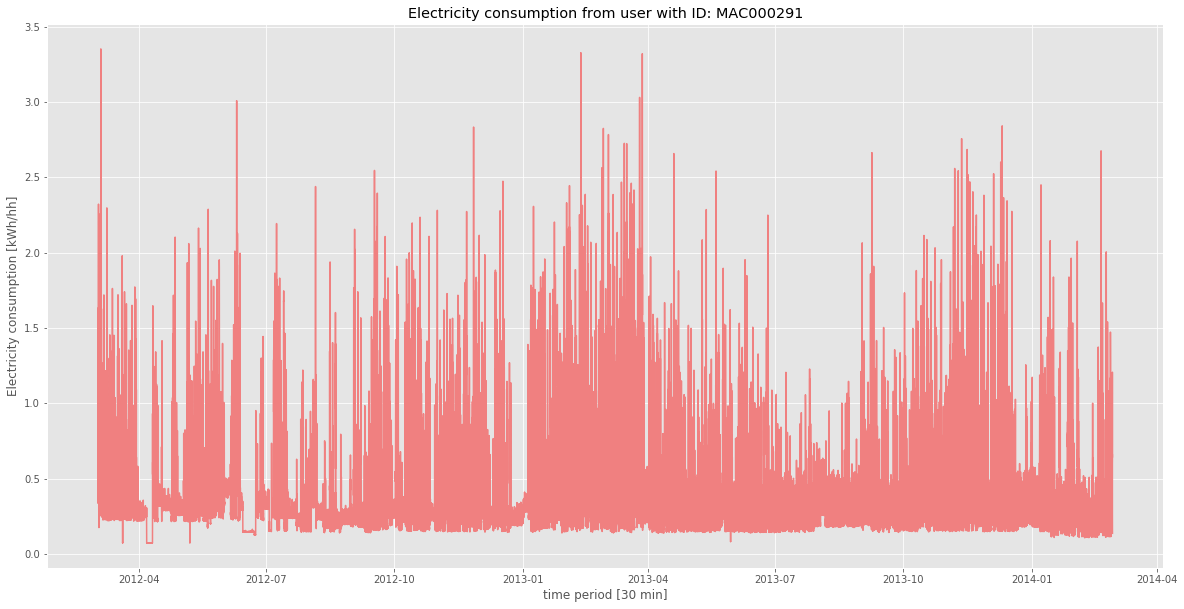

In [9]:
# Plotting the timeseries to see how the electricity consumption looks like. 
plt.figure(figsize=(20,10))
plt.plot(user_291_df.index, user_291_df['kWh/hh'], color= 'lightcoral')
plt.title('Electricity consumption from user with ID: MAC000291')
plt.xlabel('time period [30 min]')
plt.ylabel('Electricity consumption [kWh/hh]')

Text(0.5, 0, 'Time period [30 minutes]')

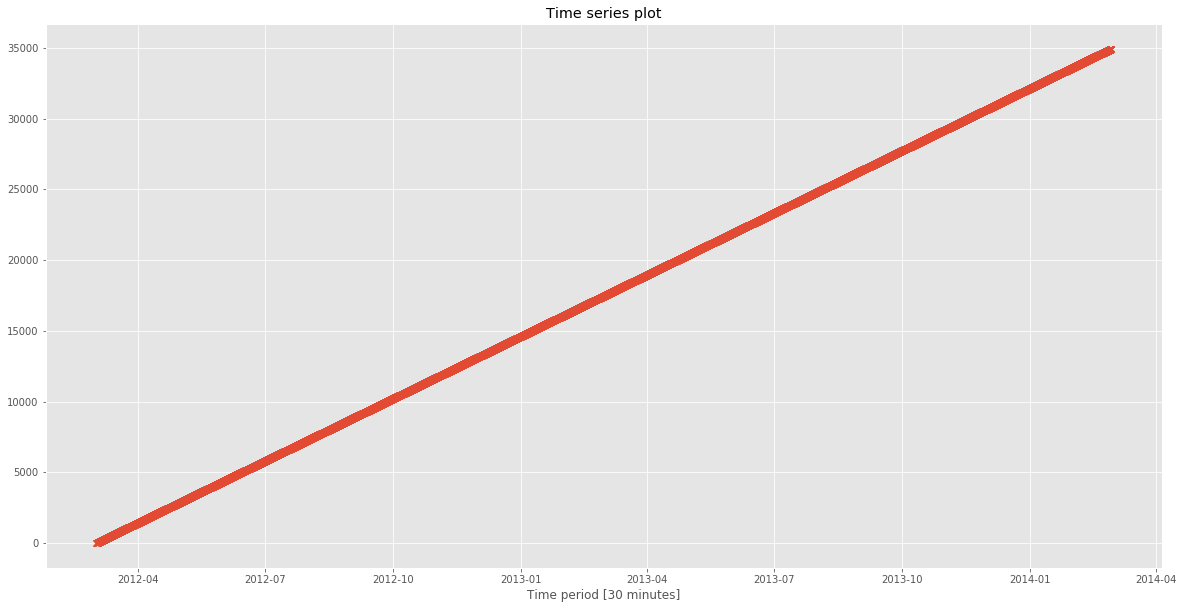

In [10]:
# Plotting to see that the evolution of the timestamp is linear and increasively, and that it is ordered. 
plt.figure(figsize=(20,10))
plt.plot(user_291_df.index, range(len(user_291_df)), 'x')
plt.title('Time series plot')
plt.xlabel('Time period [30 minutes]')

In [11]:
# Calculating the amount of data we have in 2012.
user_291_df['2012'].shape

(14620, 1)

In [12]:
# Calculating the amount of data we have in 2012.
user_291_df['2013'].shape

(17519, 1)

In [13]:
# Calculating the amount of data we have in 2012.
user_291_df['2014'].shape

(2784, 1)

In [15]:
user_291_df['2013'].head()

,kWh/hh
DateTime,
2013-01-01 00:00:00,0.228
2013-01-01 00:30:00,0.204
2013-01-01 01:00:00,0.216
2013-01-01 01:30:00,0.230
2013-01-01 02:00:00,0.258


In [16]:
user_291_df['2013'].tail()

,kWh/hh
DateTime,
2013-12-31 21:30:00,0.286
2013-12-31 22:00:00,0.274
2013-12-31 22:30:00,0.264
2013-12-31 23:00:00,0.316
2013-12-31 23:30:00,0.263


Since we want to forecast the electricity consumption of that end-user with a time resolution of 1 hour, it does not make sense to have data for more than 2 years in a timeframe of half an hour. For this reason, we will use only data from 2013 and we will resample our values into 1 hour time-period.

In [18]:
user_291_2013 = user_291_df['2013']

In [20]:
user_291_2013.head()

,kWh/hh
DateTime,
2013-01-01 00:00:00,0.228
2013-01-01 00:30:00,0.204
2013-01-01 01:00:00,0.216
2013-01-01 01:30:00,0.230
2013-01-01 02:00:00,0.258


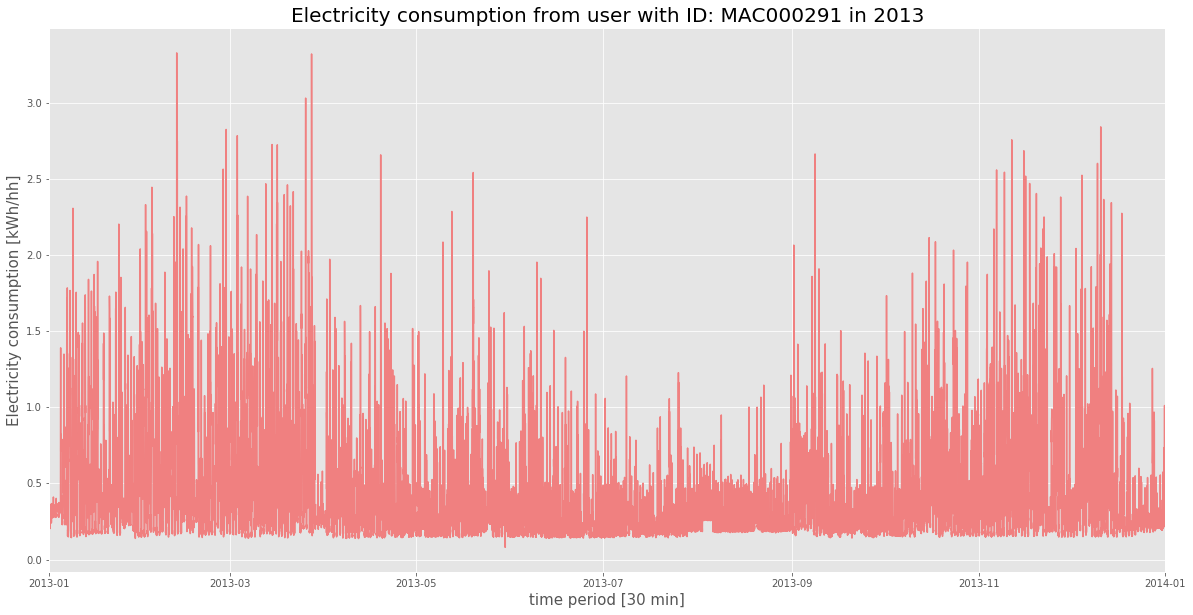

In [34]:
# Plotting the timeseries to see how the electricity consumption looks like. 
plt.figure(figsize=(20,10))
plt.plot(user_291_2013.index, user_291_2013['kWh/hh'], color= 'lightcoral')
plt.title('Electricity consumption from user with ID: MAC000291 in 2013', fontsize=20)
plt.xlabel('time period [30 min]', fontsize=15)
plt.ylabel('Electricity consumption [kWh/hh]', fontsize=15)
plt.xlim('2013-01-01 00:00:00', '2014-01-01 00:00:00')
plt.show()

In [22]:
# Resampling into 1-hour time resolution instead of 30 minutes resolution. 
user_291_2013_60=user_291_2013.resample('H').mean()

# Taking a look on what the new dataframe looks like. 
user_291_2013_60.head()

,kWh/hh
DateTime,
2013-01-01 00:00:00,0.2160
2013-01-01 01:00:00,0.2230
2013-01-01 02:00:00,0.2495
2013-01-01 03:00:00,0.2240
2013-01-01 04:00:00,0.2120


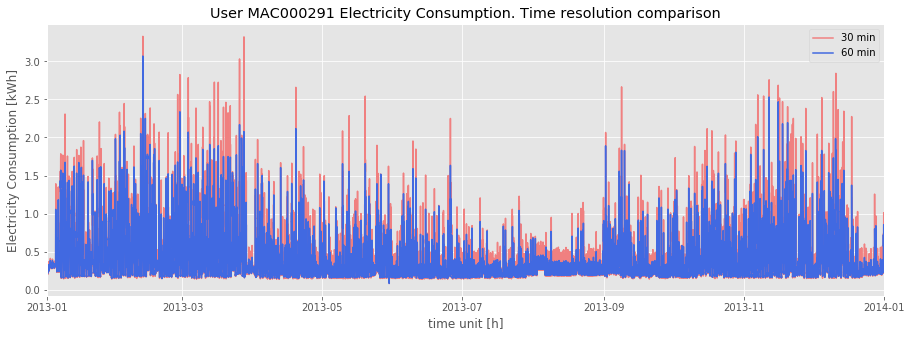

In [27]:
# Plotting both time-scale resolution 
plt.figure(figsize=(15,5))
plt.plot(user_291_2013, color='lightcoral')
plt.plot(user_291_2013_60, color='royalblue' )
plt.legend(['30 min', '60 min'], loc='upper right')
plt.title('User MAC000291 Electricity Consumption. Time resolution comparison')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-01-01 00:00:00', '2014-01-01 00:00:00')
plt.show()

### 3. Time-Series Preprocessing

Before creating a model to forecast the electricity consumption based on a TS model, we need to answer some questions. 

1. Is the electricity consumption autocorrelated? 
2. Is there a seasonality?
3. Is it stationary? 

#### Dick-Fulley Test for stationarity

Stationary is an important characteristic of Time-Series. 

We understand stationarity if its statistical properties do not change over time. That means:

- It has constant mean & variance 
- Covariance is independent of time. 

Ideally, we want a time-series to be stationary, since it makes it "easier" to model. However, if we have non-stationary data, we can remove these trends to make them stationary.

To check whether data is stationary or not, we perform a Dickey-Fuller Test. In this hipotheses these our hypotheses are: 

$H_0$: The data has a unit root and it is non-stationary (p-value > 0.05)

$H_A$: The data does not have a unit root and it is stationary (p-value <= 0.05)


When dealing with Dick-Fulley test for stationarity, we have to decide which is the window we want to use to calculate our next value, according to what we consider our seasonality. In our case, our time-scale is 1 hour. Furthermore, we can say that the value today at 12h will be similar at the value yesterday also at 12h. For this reason, we consider a window of 24 timeperiods, that means a window of 24 hours. 

In [210]:
# Importing Dickey-Fuller test for stationarity in TS
from statsmodels.tsa.stattools import adfuller

# Creating a function to calculate the stationarity test as well as some moving averages and plots. 
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,15))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

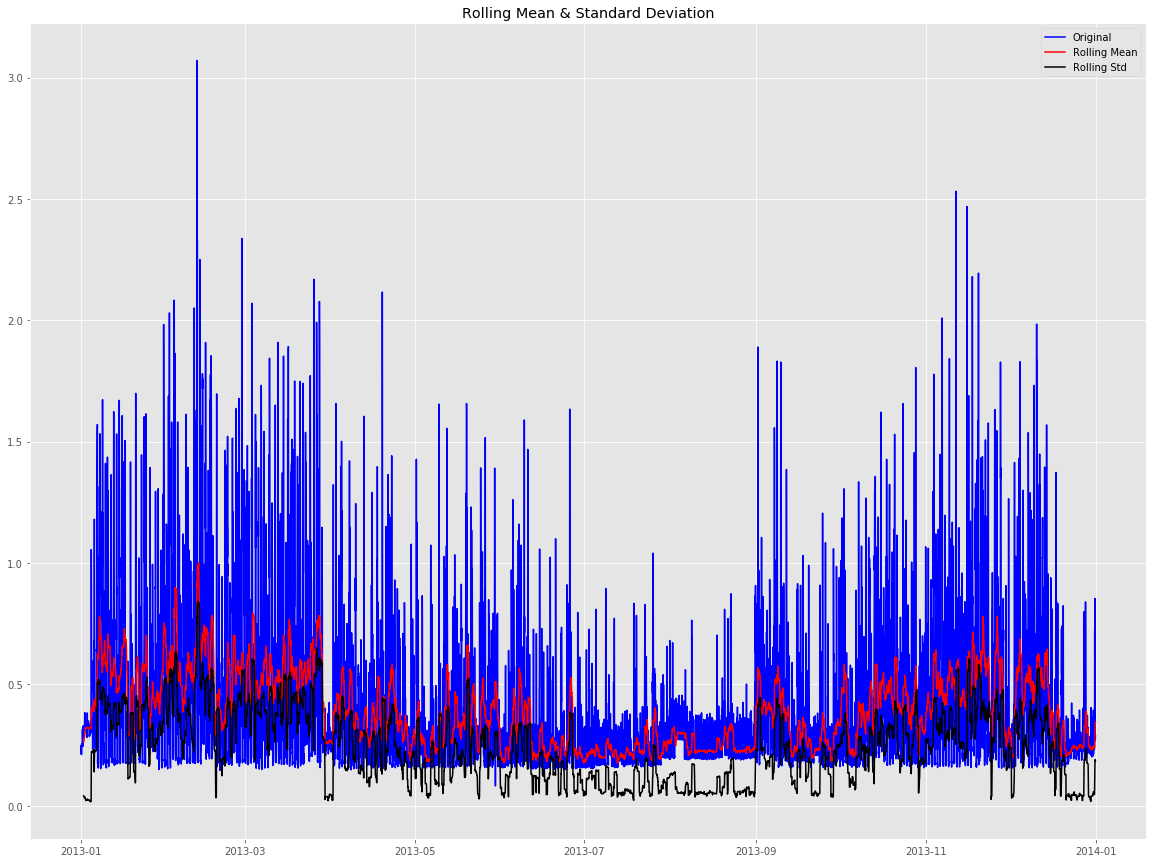

Results of Dickey-Fuller Test:
Test Statistic                -8.258769e+00
p-value                        5.150865e-13
#Lags Used                     2.700000e+01
Number of Observations Used    8.732000e+03
Critical Value (1%)           -3.431099e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


In [39]:
# Assessing the stationarity of our df based on a 24h window
test_stationarity(user_291_2013_60['kWh/hh'], window=24)

According to what we have obtained in the cell above, our p-value is equal to 5.1508e-13 and, with this information, we can reject the null hypotheses and assume that our data is stationary. 

### Plotting the moving average based on the past 24 values (the past 24h periods) 

In [40]:
#we create a moving average with 24h
moving_avg = user_291_2013_60.rolling(24).mean() 

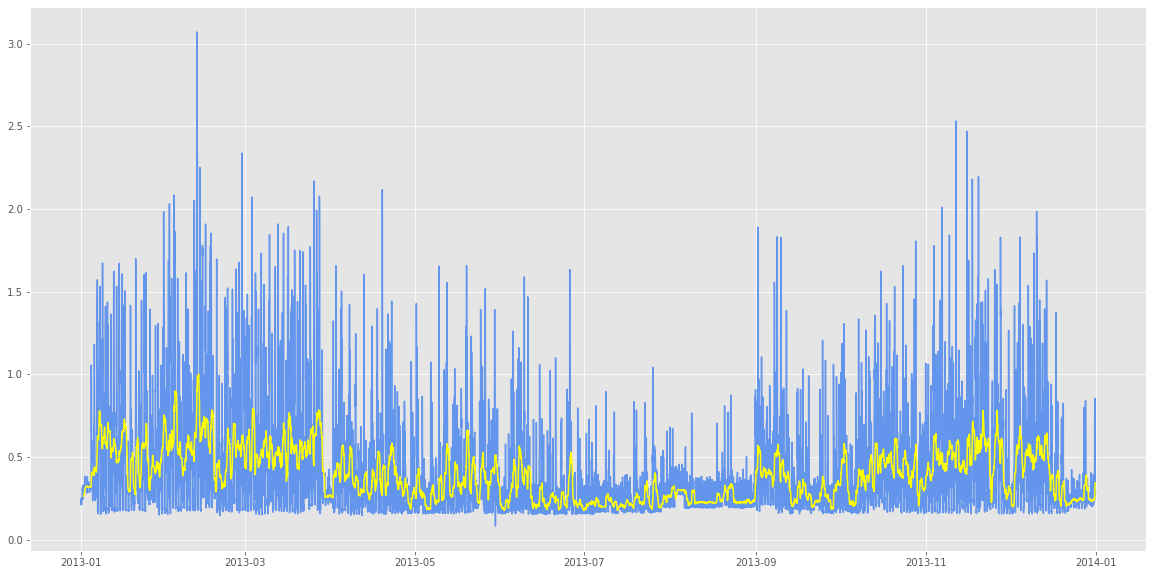

In [42]:
# Plotting the moving average with 24h of window and the entire TS 
plt.figure(figsize=(20,10))
plt.plot(user_291_2013_60, color='cornflowerblue')
plt.plot(moving_avg, color='yellow')
#plt.plot(moving_avg_200, color='pink')

plt.show()

### Time-Series Decomposition

One important step when dealing with TS is to decompose the timeseries in order to have a better understanding on what is happening behind. Hence we can understand timeseries as a sum or product of three components: trend, seasonal, residual. 

$y_{observed} = Trend + Seasonal + Residual$

$y_{observed} = Trend · Seasonal · Residual$

In the cell below we try to decompose the timeseries of 2013 with a hourly time-period.

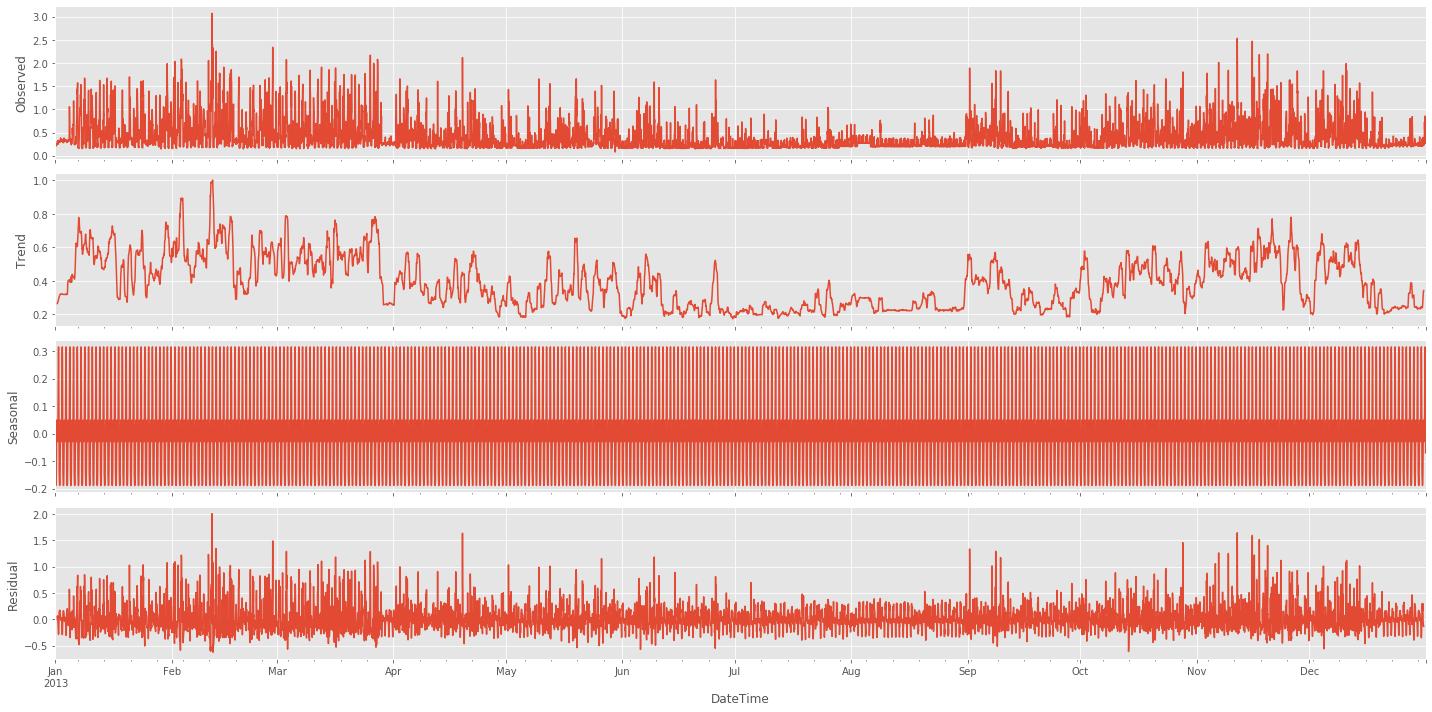

In [43]:
# Defining the figure and the figure size
plt.rcParams["figure.figsize"] = [20, 10]
# Decomposing the TS 
decomposed = sm.tsa.seasonal_decompose(user_291_2013_60)
# Plotting the decomposition
decomposed_plot = decomposed.plot()
plt.show()


When we analyze the entire year and we decompose the data, it is very difficultt to understand what's going on with the seasonal pattern. We can assume that this is because we are considering an entire year with a time-scale of 1hour. Let's see the decomposition only using 3 months of data. 

In [47]:
partial_df = user_291_2013_60['2013-01':'2013-03']

In [48]:
partial_df.head()

,kWh/hh
DateTime,
2013-01-01 00:00:00,0.2160
2013-01-01 01:00:00,0.2230
2013-01-01 02:00:00,0.2495
2013-01-01 03:00:00,0.2240
2013-01-01 04:00:00,0.2120


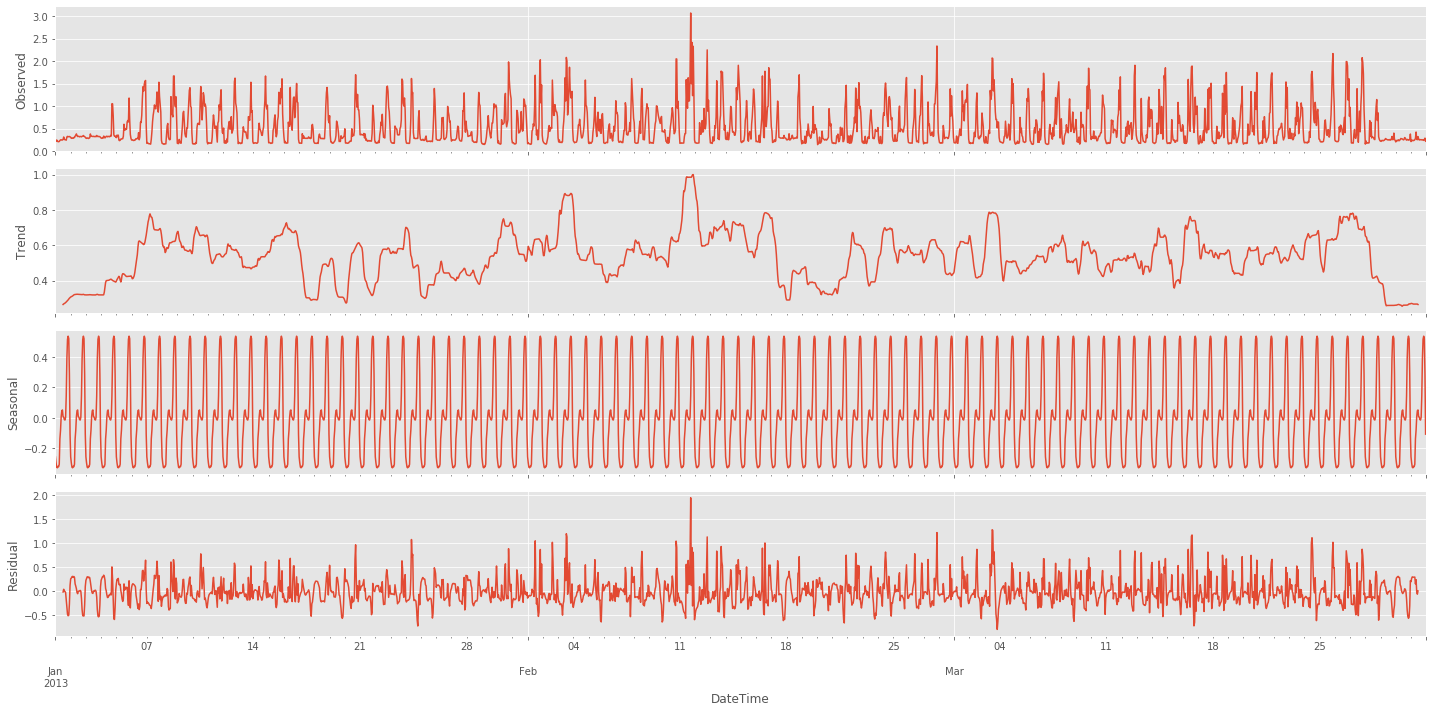

In [49]:
plt.rcParams["figure.figsize"] = [20, 10]
decomposed = sm.tsa.seasonal_decompose(partial_df)
decomposed_plot = decomposed.plot()
plt.show()


### 4. Model 1:  SARIMA Model for 2013/hourly data

We are not spliting the TS into train and test since we will consider our dataset as follows:

- Train: Data for year 2013 (hourly based)
- Test: Data for January, February 2014 (hourly based)

#### 4.1. Determining P,Q,D,S

Since we have seasonal data, we will work with a SARIMA model. In this case, we should define some parameters: 

- **p** : Maximum Lag 
- **q** : moving average
- **d** : number of differences to make the series stationary. In our case d would be equal to 0 since we have proved that our data is stationary based on the Dickey-Fuller Test. 
- **s**: Season's length 24 

In [50]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

# Calculating Autocorrelation 
lag_acf = acf(user_291_2013_60, nlags=24)

# Calculating Partial Autocorrelation
lag_pacf = pacf(user_291_2013_60, nlags=24, method='ols')

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


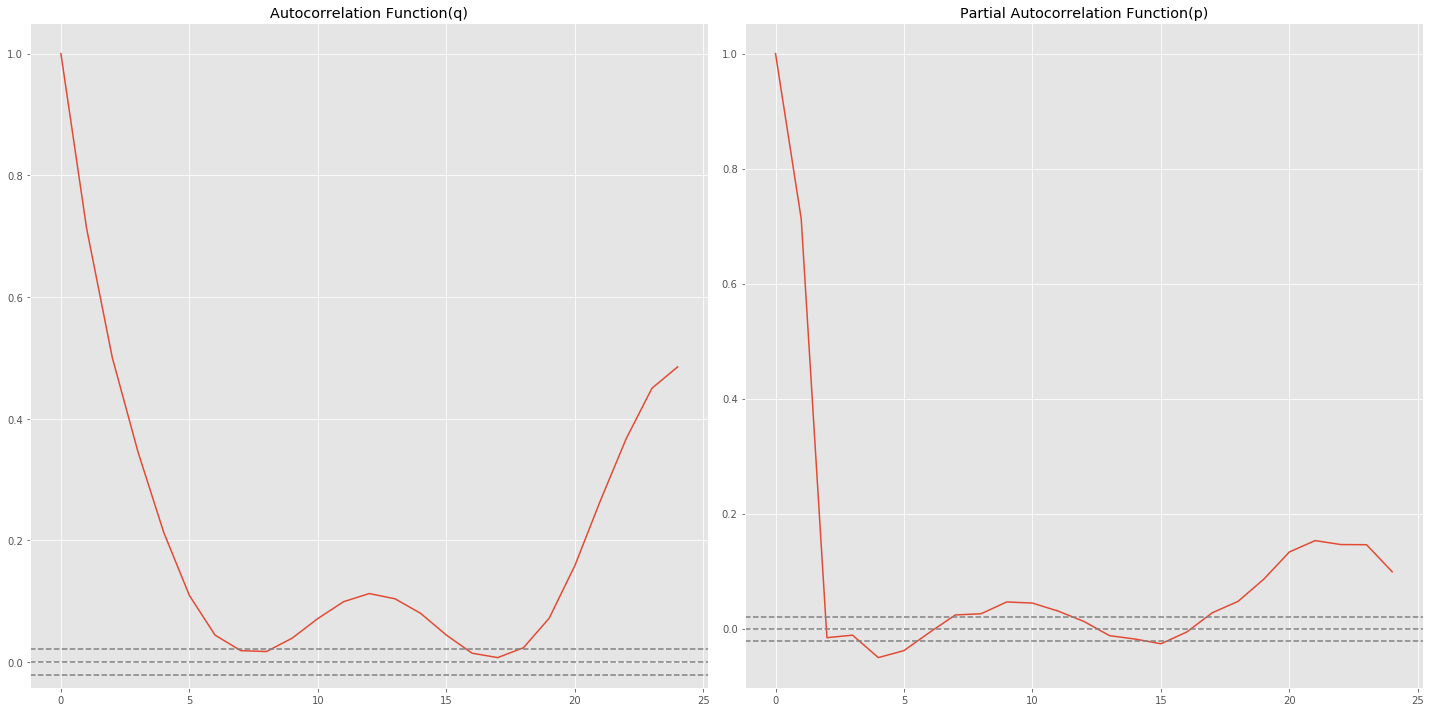

In [52]:
# Plot for ACF:
plt.subplot(121)
plt.plot(lag_acf)

# Plotting Confidence intervals for ACF
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(user_291_2013_60)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(user_291_2013_60)),linestyle='--',color='gray')
plt.title('Autocorrelation Function(q)')

# Plot for PACF:
plt.subplot(122)
plt.plot(lag_pacf)
# Plotting Confidence intervals for pACF
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(user_291_2013_60)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(user_291_2013_60)), linestyle='--', color='gray')

# Setting aesthetics of the plot
plt.title('Partial Autocorrelation Function(p)')
plt.tight_layout()

Based on the graph above, we can determine the value for q and p for our SARIMA Model. We can extract from the plots above which are the parameters when the red line crosses the upper bound of our confidence interval. 

q = 6

p = 2

https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

#### 4.2. Grid Search for hyperparameters definition

Sometimes, it can be difficult to figure out which are the hyperparameters on which to build up the model. For this reason, grid search is a useful tool that can help us to define them. In the cells below, a range for p,d,q is established and so for seasonal p,q,d. Then, all the possible combinations are calculated, the model is fit with these hyperparameters and the overall error of the model is also calculated, known as AIC. 

In [54]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(user_291_2013_60,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
        #AIC measures the error of the ARIMA method
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 24)12 - AIC:12830.98936310552
ARIMA(0, 0, 0)x(0, 0, 1, 24)12 - AIC:8739.290746465744
ARIMA(0, 0, 0)x(0, 1, 0, 24)12 - AIC:4997.870632872879
ARIMA(0, 0, 0)x(0, 1, 1, 24)12 - AIC:587.98934059219
ARIMA(0, 0, 0)x(1, 0, 0, 24)12 - AIC:4061.2777948269204
ARIMA(0, 0, 0)x(1, 0, 1, 24)12 - AIC:560.1390337551271
ARIMA(0, 0, 0)x(1, 1, 0, 24)12 - AIC:2628.109887000653


/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 24)12 - AIC:513.0977772340311
ARIMA(0, 0, 1)x(0, 0, 0, 24)12 - AIC:6119.638716638334
ARIMA(0, 0, 1)x(0, 0, 1, 24)12 - AIC:3922.0769656817433
ARIMA(0, 0, 1)x(0, 1, 0, 24)12 - AIC:2851.26554262817
ARIMA(0, 0, 1)x(0, 1, 1, 24)12 - AIC:-1978.569557363811
ARIMA(0, 0, 1)x(1, 0, 0, 24)12 - AIC:1429.9502290244272
ARIMA(0, 0, 1)x(1, 0, 1, 24)12 - AIC:-2013.6770498724734
ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:379.0706404805476
ARIMA(0, 0, 1)x(1, 1, 1, 24)12 - AIC:-2011.581510837487
ARIMA(0, 1, 0)x(0, 0, 0, 24)12 - AIC:-111.32067433217787
ARIMA(0, 1, 0)x(0, 0, 1, 24)12 - AIC:-189.0814667133904
ARIMA(0, 1, 0)x(0, 1, 0, 24)12 - AIC:4832.751143188348
ARIMA(0, 1, 0)x(0, 1, 1, 24)12 - AIC:-817.1085541894822
ARIMA(0, 1, 0)x(1, 0, 0, 24)12 - AIC:-215.73848233782326
ARIMA(0, 1, 0)x(1, 0, 1, 24)12 - AIC:-866.7337112553627
ARIMA(0, 1, 0)x(1, 1, 0, 24)12 - AIC:2245.7792870552557
ARIMA(0, 1, 0)x(1, 1, 1, 24)12 - AIC:-815.0869159654749
ARIMA(0, 1, 1)x(0, 0, 0, 24)12 - AIC:-305.552677580

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 24)12 - AIC:-2842.36799964355
ARIMA(1, 1, 0)x(0, 0, 0, 24)12 - AIC:-258.796327017405
ARIMA(1, 1, 0)x(0, 0, 1, 24)12 - AIC:-387.3671122625634


/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 24)12 - AIC:4295.893524011121
ARIMA(1, 1, 0)x(0, 1, 1, 24)12 - AIC:-1287.4534629624093
ARIMA(1, 1, 0)x(1, 0, 0, 24)12 - AIC:-434.1024438543815
ARIMA(1, 1, 0)x(1, 0, 1, 24)12 - AIC:-1336.8793017207518
ARIMA(1, 1, 0)x(1, 1, 0, 24)12 - AIC:1742.6627426991931
ARIMA(1, 1, 0)x(1, 1, 1, 24)12 - AIC:-1285.45288099162
ARIMA(1, 1, 1)x(0, 0, 0, 24)12 - AIC:-1619.2139242790104
ARIMA(1, 1, 1)x(0, 0, 1, 24)12 - AIC:-1815.484554878618
ARIMA(1, 1, 1)x(0, 1, 0, 24)12 - AIC:2386.8686058330595
ARIMA(1, 1, 1)x(0, 1, 1, 24)12 - AIC:-2921.6815809320815
ARIMA(1, 1, 1)x(1, 0, 0, 24)12 - AIC:-1899.5570778265028
ARIMA(1, 1, 1)x(1, 0, 1, 24)12 - AIC:-2976.3332553811447
ARIMA(1, 1, 1)x(1, 1, 0, 24)12 - AIC:-122.6467024487086
ARIMA(1, 1, 1)x(1, 1, 1, 24)12 - AIC:-2917.826413291847


The parameters that gives us the best performance of the model are: 

**ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:379.0706404805476**

Let's create the model with the parameters we have considered above:

In [59]:
# Instantiating the model using the parameters with the lowest AIC. 
mod = sm.tsa.statespace.SARIMAX(user_291_2013_60,
                                order=(0, 0, 1),
                                seasonal_order=(1, 1, 0, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fitting the model 
results = mod.fit()

# Print the table of results
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4560      0.006     72.046      0.000       0.444       0.468
ar.S.L24      -0.4989      0.005    -96.113      0.000      -0.509      -0.489
sigma2         0.0611      0.000    134.304      0.000       0.060       0.062


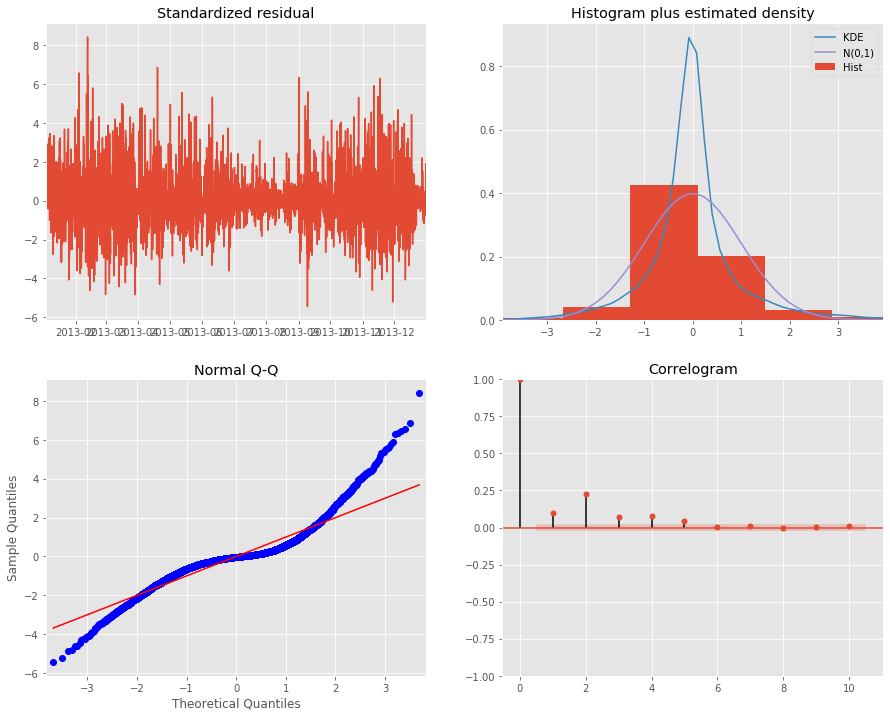

In [56]:
# Plotting the results plot, residual analysis
results.plot_diagnostics(figsize=(15, 12))
plt.show()

When we plot the residuals, we want to prove that they are normally distributed. When we can prove that the residuals are normally distributed, we can say that our model is likely to be fit in a proper way. However, when we take a look at the plots we have above, we can clearly see that our model's residuals are not normally distributed. the Normal Q-Q plot residual plot are not alongside the line, as well as the residual distribution KDE is not likely to follow a normal distribution with N(0,1). That means that we should change our hyperparameters.

Let's try a different model with different hypeparameters: 


In [57]:
# Creating a new SARIMA model with different parameters
mod = sm.tsa.statespace.SARIMAX(user_291_2013_60,
                                order=(2, 0, 6),
                                seasonal_order=(1, 1, 0, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fitting the model 
results = mod.fit()

# Printing the results
print(results.summary().tables[1])

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0606      0.354      2.995      0.003       0.367       1.755
ar.L2         -0.1608      0.220     -0.730      0.465      -0.592       0.271
ma.L1         -0.5384      0.354     -1.520      0.128      -1.233       0.156
ma.L2         -0.1456      0.071     -2.062      0.039      -0.284      -0.007
ma.L3         -0.0228      0.042     -0.547      0.584      -0.104       0.059
ma.L4         -0.0163      0.019     -0.854      0.393      -0.054       0.021
ma.L5         -0.0040      0.017     -0.243      0.808      -0.036       0.028
ma.L6         -0.0455      0.017     -2.724      0.006      -0.078      -0.013
ar.S.L24      -0.5035      0.005    -93.888      0.000      -0.514      -0.493
sigma2         0.0574      0.000    132.201      0.000       0.057       0.058


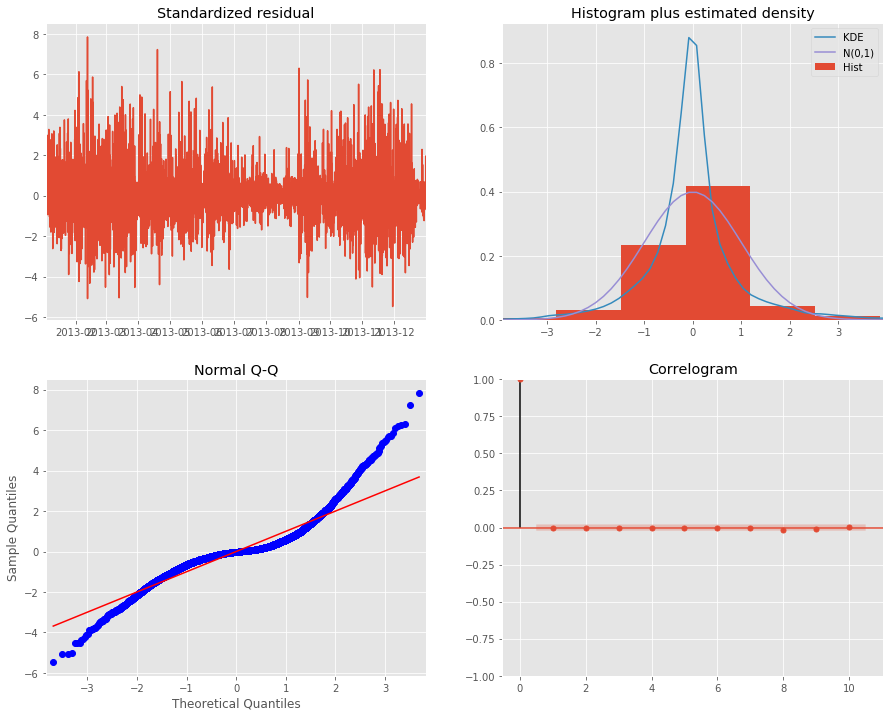

In [58]:
# Plotting the residuals plot
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In this case, we can see again that the residual distribution is even worse than in the first model. We will discard this model and we will make predictions with the first one. 

### 4.3. Making predictions in 2014. 
We have considered 2013 as our train set, and we will make predictions for 2014. Again, we are considering supervised learning, since we have the target variable on our test set and we can compare both results. 

In [109]:
# Predicting values for 2014 first 2 months.
pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), end=pd.to_datetime('2014-02-28 00:00:00'), dynamic=False)

# Calculating the confidence interval for these two months
pred_ci = pred.conf_int()

In this case, we will use the users data for 2013 and 2014, resampled into 1 hour timeframe. 

In [67]:
# Resampling into 1-hour time resolution instead of 30 minutes resolution. 
user_291_1314_60 = user_291_df['2013':].resample('H').mean()

# Taking a look on what the new dataframe looks like. 
user_291_1314_60 .head()

,kWh/hh
DateTime,
2013-01-01 00:00:00,0.2160
2013-01-01 01:00:00,0.2230
2013-01-01 02:00:00,0.2495
2013-01-01 03:00:00,0.2240
2013-01-01 04:00:00,0.2120


We will plot the forecast values as well as the test value, to see whether the forecast is accurated or not. 

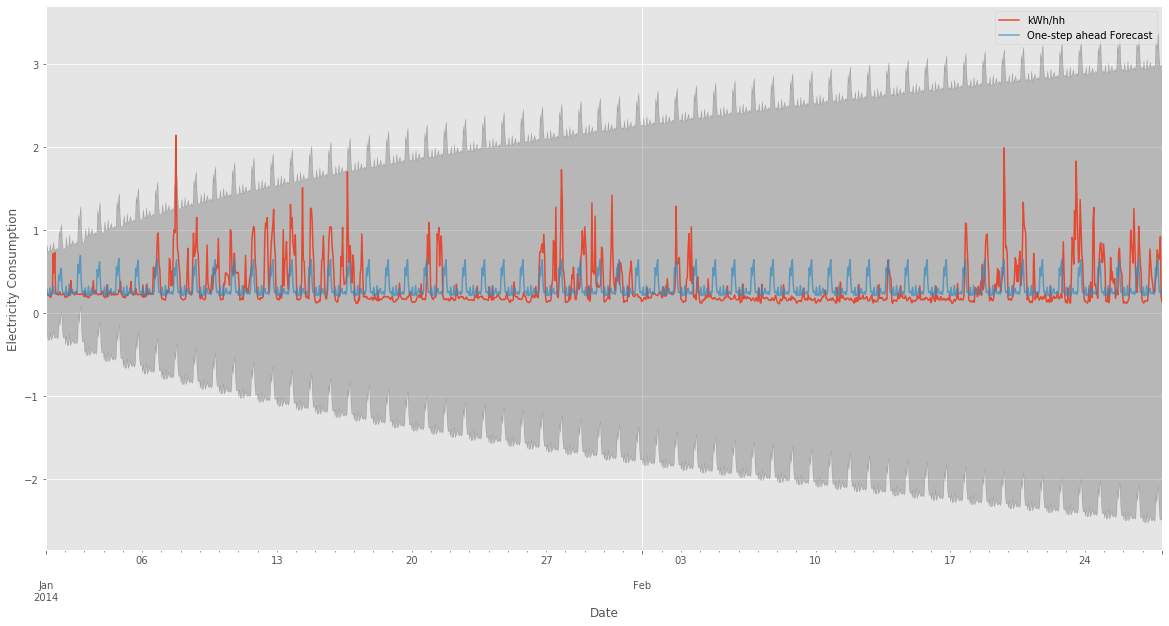

In [91]:
ax = user_291_1314_60.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlim('2014-01-01', '2014-02-28')
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Consumption')
plt.legend()

plt.show()

In [113]:
from sklearn.metrics import mean_squared_error

y_forecasted = pred.predicted_mean
y_truth = user_291_1314_60['2014-01-01':'2014-02-28 00:00:00']

# Compute the mean square error
print('The Mean Squared Error of our forecasts is {}'.format(round(mean_squared_error(y_truth, y_forecasted), 2)))

The Mean Squared Error of our forecasts is 0.07


As we can see from the plot above and also from the MSE, even if the MSE is quite low, it does not mean that the performance of the model is good at all. In this case, we could conclude that we have too much data in such a great granularity (1 year of data in 1hour timescale), that means that we are not generalizing the model in order to be able to predict, and also we are not learning the patterns of the model to clearly predict the next outcome. 

### 5. Model 2: Creating a new model for daily energy consumption forecasting. 

In order to do that, we will resample our dataframe into a timescale of days. Also, since we are working with electricity consumption, we will resample the df and we will calculate the sum, in order to obtain the total kWh consumed in that period of 1 hours. 

In [117]:
# Resampling the df into an hourly timescale. 
user_291_month_daily  = user_291_2013_60.resample('D').sum()

In [119]:
# Changing the name of the columns 
user_291_month_daily.columns = ['kWh/day']

In this case, we will use 5 months in a daily timescale as a train set, and we will use 2 months on 2013 to be our test set. 

In [153]:
# Choosing 5 months to be our train set 
train_set = user_291_month_daily['2013-01':'2013-05']

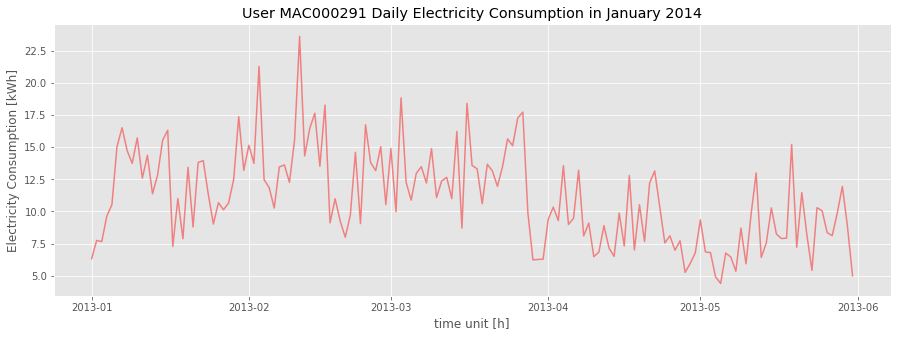

In [154]:
# Plotting the time-series 
plt.figure(figsize=(15,5))
plt.plot(train_set, color='lightcoral')
plt.title('User MAC000291 Daily Electricity Consumption in January 2014')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.show()

### 5.1 Checking stationarity (Dickey-Fuller Test)

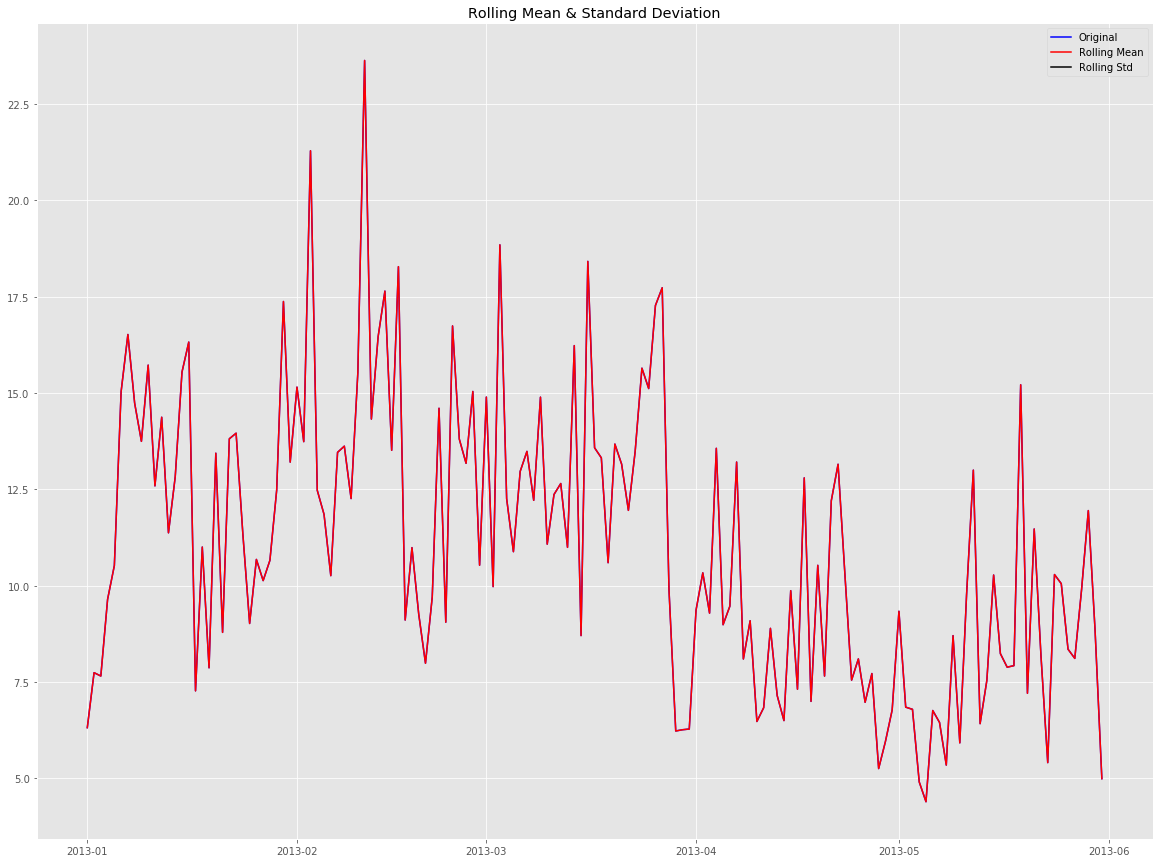

Results of Dickey-Fuller Test:
Test Statistic                  -4.083306
p-value                          0.001032
#Lags Used                       1.000000
Number of Observations Used    149.000000
Critical Value (1%)             -3.475018
Critical Value (5%)             -2.881141
Critical Value (10%)            -2.577221
dtype: float64


In [155]:
# Checking stationarity for this new df, with a window of 1 day. 
test_stationarity(train_set['kWh/day'], window=1)

According to the p-value we have obtained, we can say that our data is stationary in this case.

### 5.2. TS Decomposition

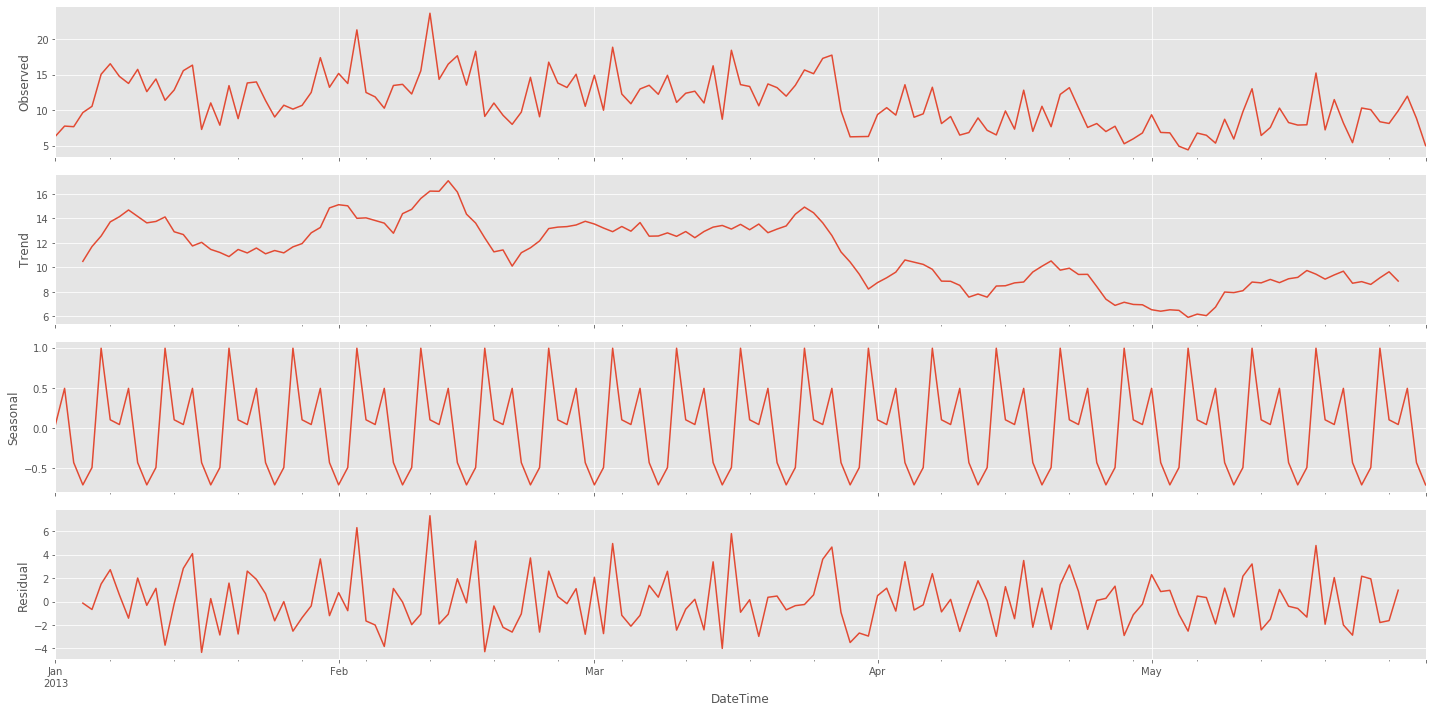

In [156]:
plt.rcParams["figure.figsize"] = [20, 10]
decomposed = sm.tsa.seasonal_decompose(train_set)
decomposed_plot = decomposed.plot()
plt.show()


In [165]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

param_list=[]


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_set,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            param_list.append(results.aic)
        #AIC measures the error of the ARIMA method
        except:
            continue
print(min(param_list))

ARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:1165.3487876847303
ARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:1008.6433198565272
ARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:833.7478400542436
ARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:734.0123770472129
ARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC:837.7503349051519
ARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC:761.5184843375843
ARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:762.6974301449113
ARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:736.7935386354407
ARIMA(0, 0, 1)x(0, 0, 0, 7) - AIC:1038.6478038445211
ARIMA(0, 0, 1)x(0, 0, 1, 7) - AIC:937.1256084397717
ARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC:825.0912111788411
ARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:722.463586787394
ARIMA(0, 0, 1)x(1, 0, 0, 7) - AIC:833.7920301562782
ARIMA(0, 0, 1)x(1, 0, 1, 7) - AIC:745.5365705646307
ARIMA(0, 0, 1)x(1, 1, 0, 7) - AIC:761.7061462209731
ARIMA(0, 0, 1)x(1, 1, 1, 7) - AIC:727.0082249204866
ARIMA(0, 1, 0)x(0, 0, 0, 7) - AIC:813.138812421806
ARIMA(0, 1, 0)x(0, 0, 1, 7) - AIC:779.7821932378472
ARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC:891.9848191841982
ARIMA(0, 1,

ARIMA(0, 1, 1)x(1, 1, 1, 7) - AIC:692.3087971266589

In this case, we choose the hyperparameters that lead to the minimum AIC and we calculate the model with that, in order to test the normality of the residuals. 

In [166]:
mod = sm.tsa.statespace.SARIMAX(train_set,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7652      0.054    -14.160      0.000      -0.871      -0.659
ar.S.L7       -0.2019      0.094     -2.137      0.033      -0.387      -0.017
ma.S.L7       -1.0000   1410.605     -0.001      0.999   -2765.735    2763.735
sigma2         8.3119   1.17e+04      0.001      0.999    -2.3e+04     2.3e+04


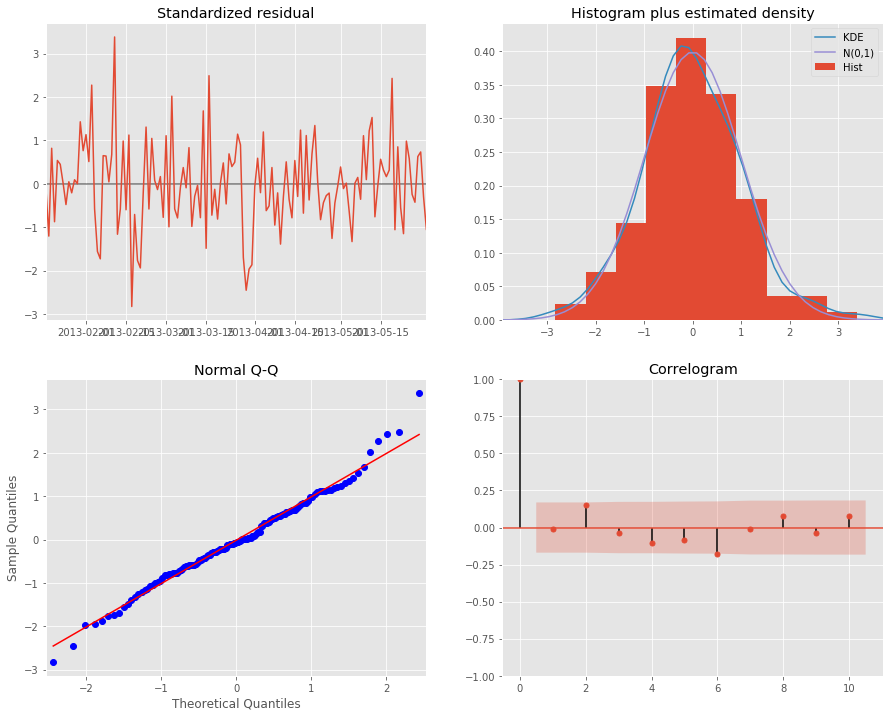

In [167]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

From the plot above we can see that the performance of this model is clearly better than in the previous case. 

#### 5.3. Predicting electricity consumption for May and June 2013. 

In [168]:
pred = results.get_prediction(start=pd.to_datetime('2013-05-01'), end=pd.to_datetime('2013-07-01 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()

#### 5.4. Plotting the test_set, the y_pred and the confidence intervals

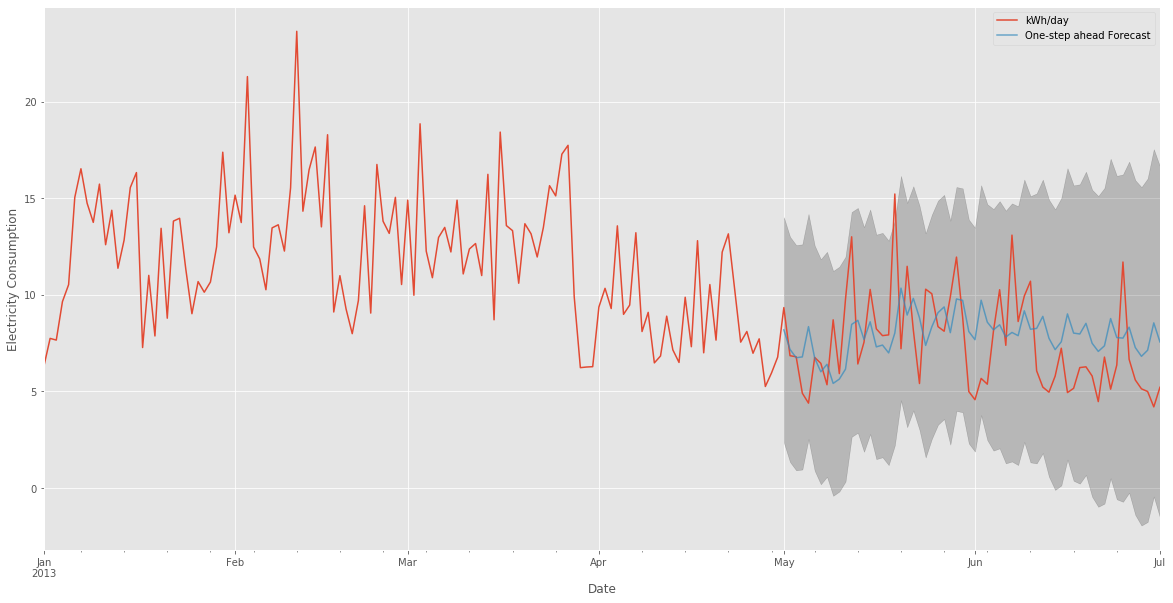

In [169]:
ax = user_291_month_daily['2013-01-01':'2013-07-01'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
#ax.set_xlim('2014-01-01', '2014-02-28')
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Consumption')
plt.legend()

plt.show()

In [182]:
from sklearn.metrics import mean_squared_error

y_forecasted = pred.predicted_mean
y_truth = user_291_month_daily['2013-05-01':'2013-07-01']

# Compute the mean square error
print('The Mean Squared Error of our forecasts is {}'.format(round(mean_squared_error(y_truth, y_forecasted), 2)))

The Mean Squared Error of our forecasts is 6.49


### 6. Model 3: Taking one year data from 2013 (one-day basis) to predict 1 month in 2014

In this last model, we consider one year of data in a daily basis, and 2013 will be our train test. We will consider our test set as January, February and March 2014 to predict the electricity consumption of the end-user MAC000291.

In [174]:
# Splitting our dataset for train.
train_set2 = user_291_month_daily['2013']

In [175]:
train_set2.head()

,kWh/day
DateTime,
2013-01-01,6.3150
2013-01-02,7.7425
2013-01-03,7.6550
2013-01-04,9.6460
2013-01-05,10.5235


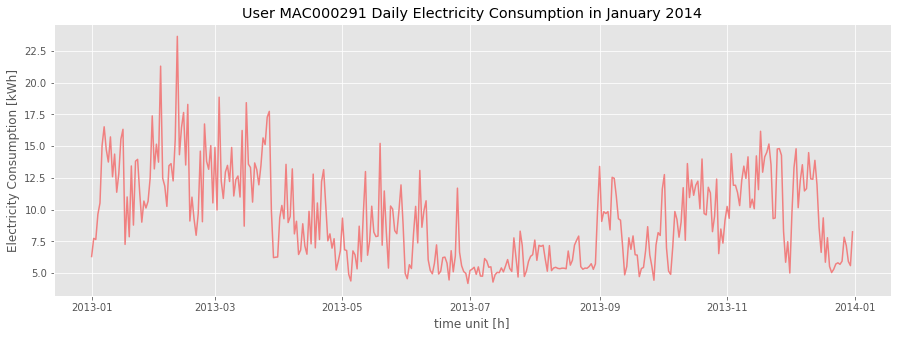

In [176]:
# Plotting the TS Electricity consumption in 2013. 
plt.figure(figsize=(15,5))
plt.plot(train_set2, color='lightcoral')

# Setting aesthetics of the plot.
plt.title('User MAC000291 Daily Electricity Consumption in 2013')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.show()

###    6.1. Dickey-Fuller Test


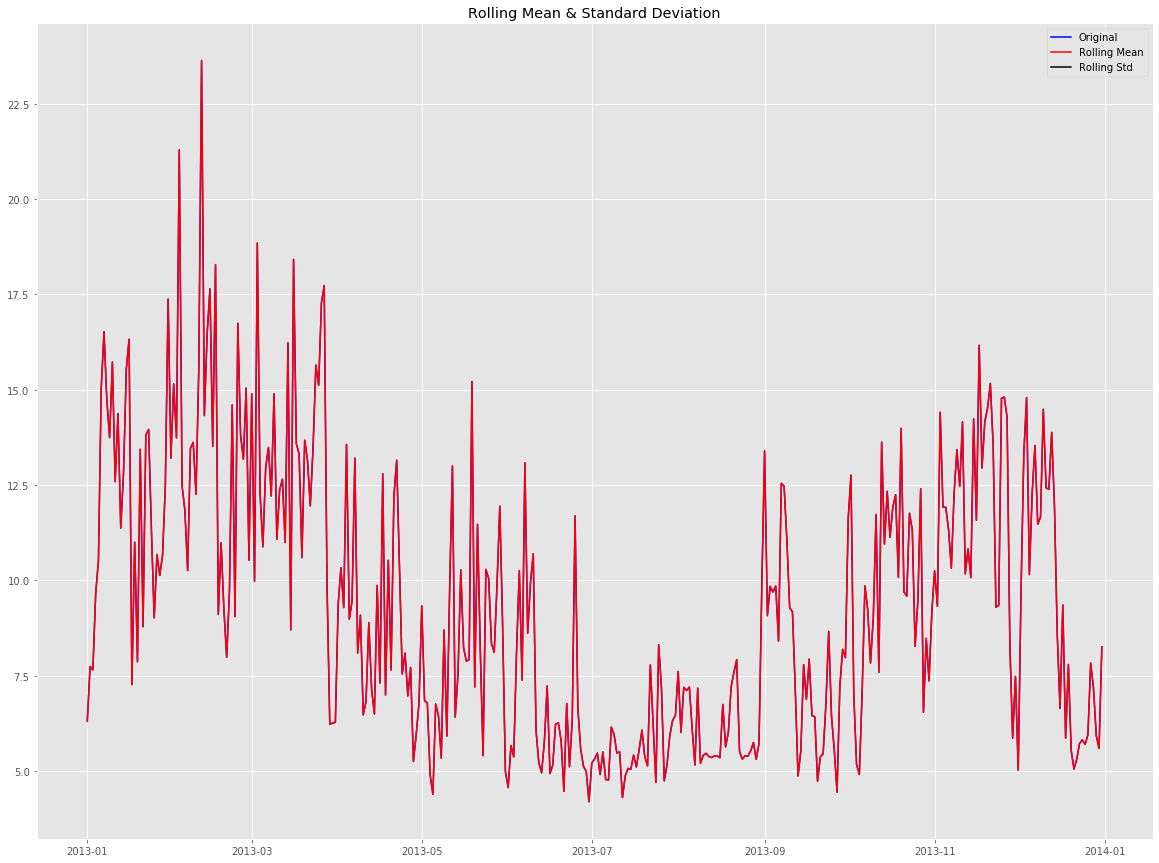

Results of Dickey-Fuller Test:
Test Statistic                  -2.672116
p-value                          0.078989
#Lags Used                       7.000000
Number of Observations Used    357.000000
Critical Value (1%)             -3.448801
Critical Value (5%)             -2.869670
Critical Value (10%)            -2.571101
dtype: float64


In [177]:
test_stationarity(train_set2['kWh/day'], window=1)

Our p-value is greater than 0.05. That means that we cannot reject the null hypotheses and our data is not stationary. For this reason, we need to include differentiation in our data. 
###   6.2. Arranging non-stationary Time-Series. Differentiation

In [191]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return pd.DataFrame(diff)


In [193]:
train_set2_diff = train_set2['kWh/day'] - train_set2['kWh/day'].shift(1)

In [196]:
train_set2_diff.dropna(inplace=True)

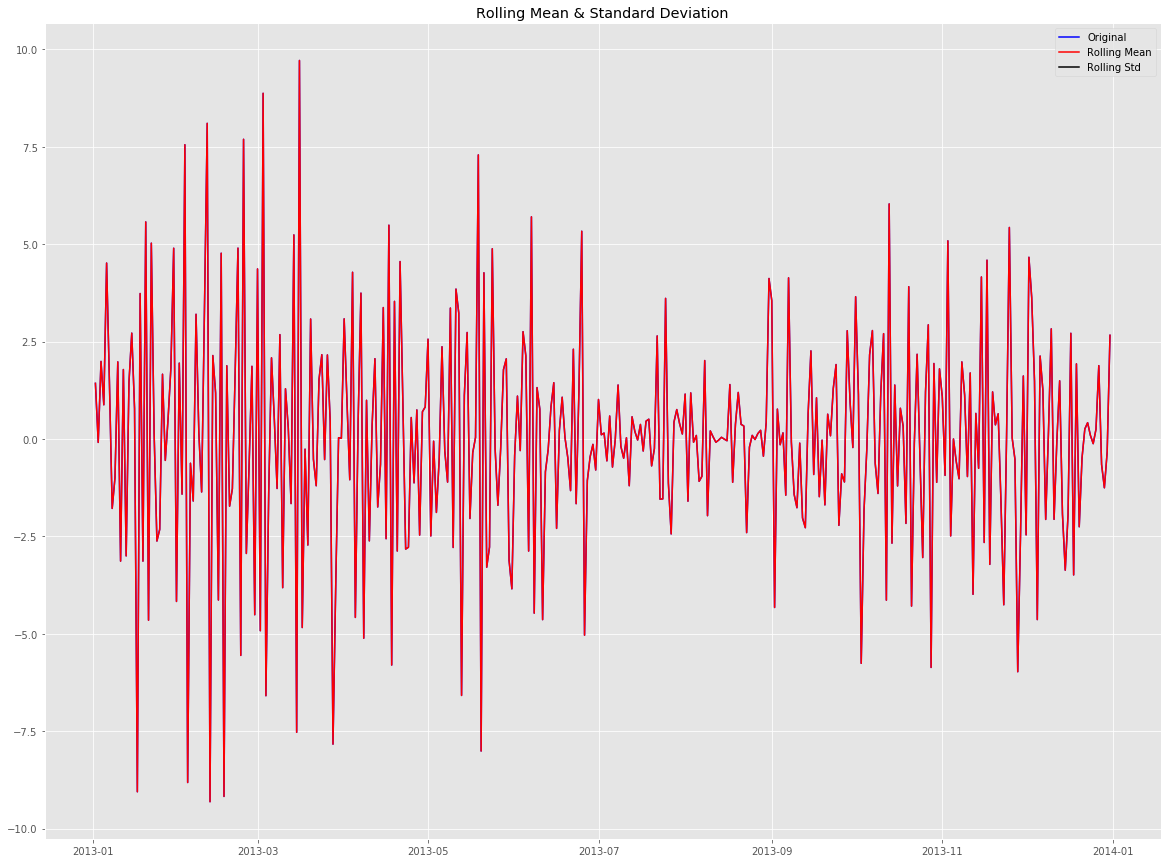

Results of Dickey-Fuller Test:
Test Statistic                -7.975563e+00
p-value                        2.708329e-12
#Lags Used                     1.100000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64


In [199]:
test_stationarity(train_set2_diff, window=1)

Thanks to differentiation, we can see that the p-value right now is lower than 0.05, meaning that we can reject the null hypotheses and consider our TS to be stationary. We can create and fit the model. 

### 6.3. Grid-Search for SARIMA model. 


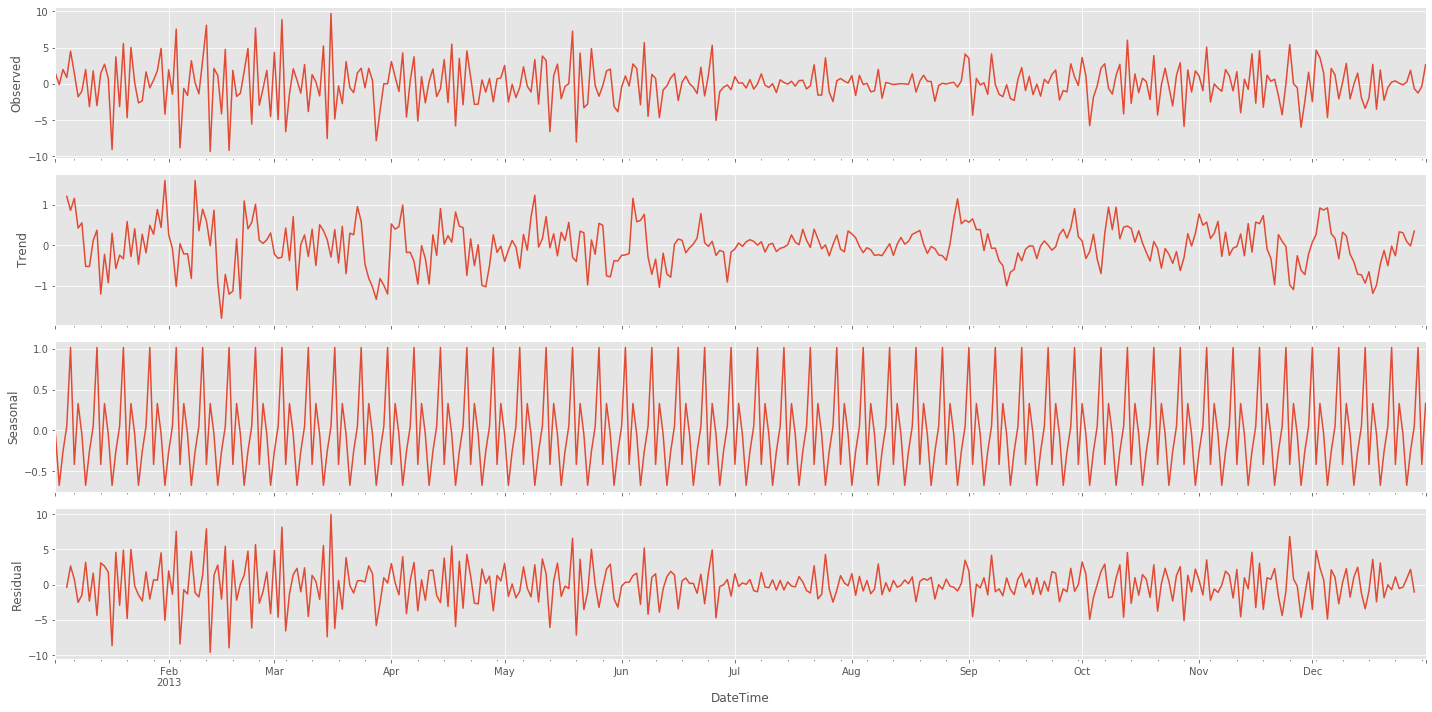

In [197]:
plt.rcParams["figure.figsize"] = [20, 10]
decomposed = sm.tsa.seasonal_decompose(train_set2_diff)
decomposed_plot = decomposed.plot()
plt.show()


In [200]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

param_list=[]


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_set2_diff,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            param_list.append(results.aic)
        #AIC measures the error of the ARIMA method
        except:
            continue
print(min(param_list))

ARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:1797.0760851631185
ARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:1767.6165008075905
ARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:2016.8261198686832
ARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:1748.5677436715932
ARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC:1771.6550228111919
ARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC:1761.7798214386385
ARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:1898.828300876226
ARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:1750.567182187547
ARIMA(0, 0, 1)x(0, 0, 0, 7) - AIC:1690.5584261383956
ARIMA(0, 0, 1)x(0, 0, 1, 7) - AIC:1656.9763765219282
ARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC:1914.2625809424808
ARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:1634.8008864440208
ARIMA(0, 0, 1)x(1, 0, 0, 7) - AIC:1664.2442570294954
ARIMA(0, 0, 1)x(1, 0, 1, 7) - AIC:1656.9801962058154
ARIMA(0, 0, 1)x(1, 1, 0, 7) - AIC:1793.8308980699603
ARIMA(0, 0, 1)x(1, 1, 1, 7) - AIC:1636.9538916726638
ARIMA(0, 1, 0)x(0, 0, 0, 7) - AIC:2179.784339479544
ARIMA(0, 1, 0)x(0, 0, 1, 7) - AIC:2144.3663366142146
ARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC:2399.8944987796

ARIMA(1, 0, 1)x(0, 1, 1, 7) - AIC:1633.2870926740607

In [202]:
mod = sm.tsa.statespace.SARIMAX(train_set2_diff,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2351      0.062      3.810      0.000       0.114       0.356
ma.L1         -0.8226      0.041    -20.040      0.000      -0.903      -0.742
ma.S.L7       -1.0000     56.667     -0.018      0.986    -112.066     110.066
sigma2         5.8415    331.017      0.018      0.986    -642.939     654.622


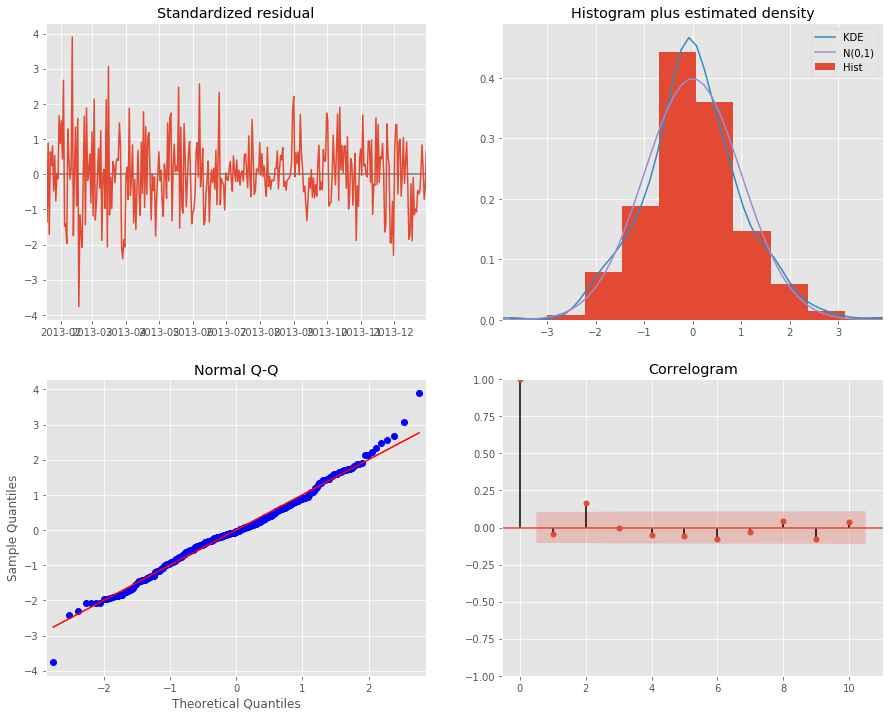

In [203]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

###     6.4. Predicting values for January, February and March 2014

In [204]:
pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), end=pd.to_datetime('2014-03-01 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()

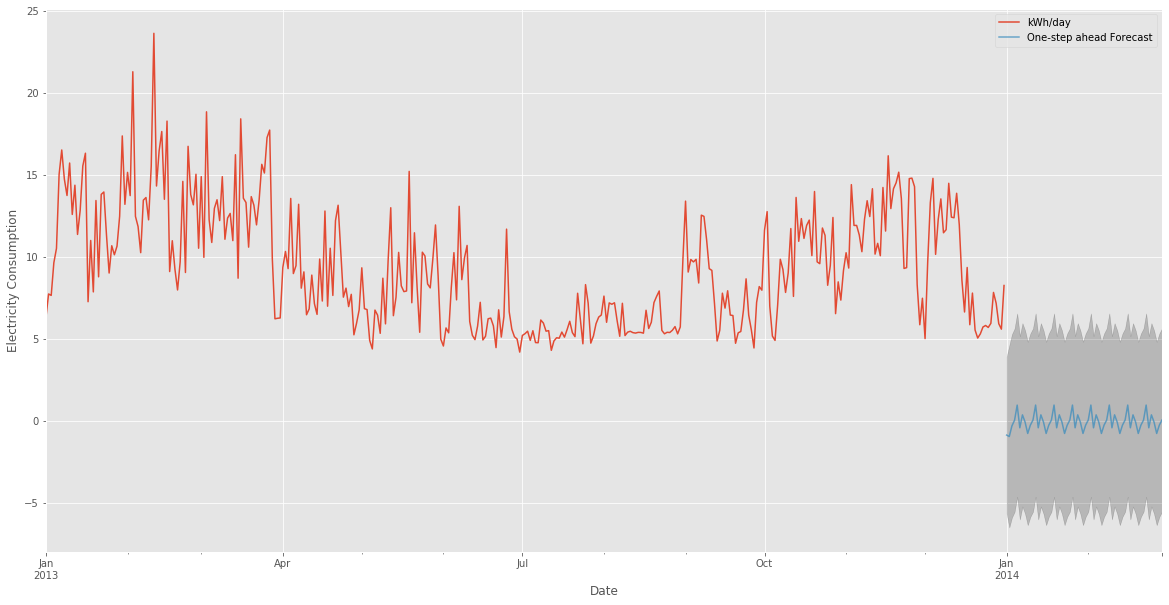

In [209]:
ax = user_291_month_daily['2013-01-01':'2014-03-01'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
#ax.set_xlim('2014-01-01', '2014-02-28')
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Consumption')
plt.legend()

plt.show()

As we can see from the plot above, since we have fit our model using differentiated data, we need to transform again this vector to be a vector of electricity consumption and not a vector of differences from the time-period before (1 day). However, due to time constraints, this is not done right now and will be done in the near future. 